# 项目2：量子电路编译算法，本说明还在施工中！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from routing_lib import Q_circuit

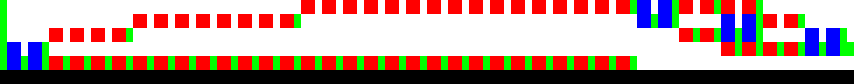

In [2]:
qc = Q_circuit()
qc.load_test(2)
img = qc.plot_circuit(7) # 参数是图像缩放

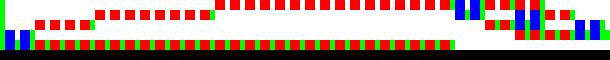

In [3]:
qc.routing()  # 你需要完成的部分
img = qc.plot_circuit()

In [4]:
qc.compute_fed()
print(qc.fed_logi_ave)

0.9783654313674999


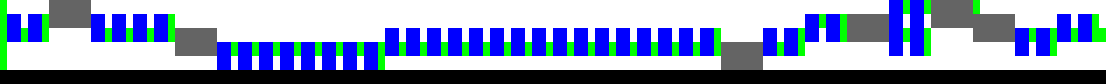

In [5]:
qc.mpping_by_qiskit()
img = qc.plot_circuit(ex_in=7)

In [6]:
qc.compute_fed()
print(qc.fed_logi_ave)

0.9717893844833785


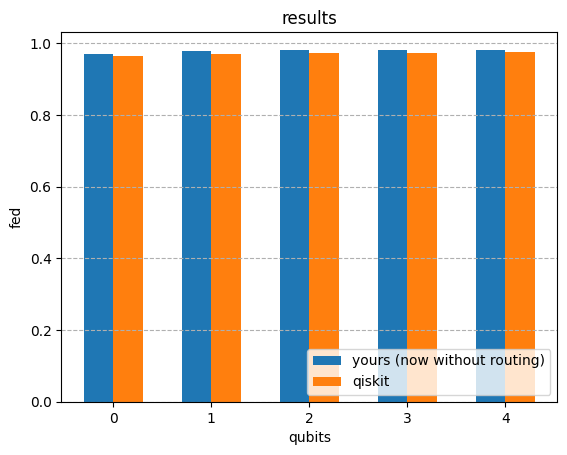

In [7]:
qc = Q_circuit()
qc.load_test(2)
qc.routing()  # 你需要完成的部分
qc.compute_fed()
list1 = sorted(qc.fed_logi_list)
qc.mpping_by_qiskit()
qc.compute_fed()
list2 = sorted(qc.fed_logi_list)

labels = [i for i in range(len(list1))]
x = np.arange(len(labels))
width = 0.3  # 每个柱子的宽度
fig, ax = plt.subplots()
ax.bar(x - 0.15, list1, width, label='yours (now without routing)')
ax.bar(x +0.15, list2, width, label='qiskit')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('qubits')
ax.set_ylabel('fed')
ax.set_title('results')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', which='both', axis='y')  # 虚线网格
plt.show()